In [2]:
import xgboost as xgb
import polars as pl
from sklearn import model_selection, linear_model, neighbors, svm
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import tree
from sklearn import preprocessing

# Data Science Project - Model Training

## Data loading:

In [2]:
data = pl.read_parquet("clean_data.parquet")
# data

## Preparing data for model training:

In [3]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(data.drop(["Criminality", "Resilience","Continent", "Region"]), data.select(["Criminality", "Resilience"]), test_size=0.2, random_state=42)
scaler = preprocessing.MinMaxScaler()
X_train_data = pl.DataFrame(scaler.fit_transform(X_train.drop("Country")))
X_train_data.columns = X_train.drop("Country").columns
X_test_data = pl.DataFrame(scaler.transform(X_test.drop("Country")))
X_test_data.columns = X_test.drop("Country").columns
countries_train = X_train["Country"]
countries_test = X_test["Country"]
res_train = (y_train["Resilience"]-1)/10
res_test = (y_test["Resilience"]-1)/10
cri_train = (y_train["Criminality"]-1)/10
cri_test = (y_test["Criminality"]-1)/10

## Feature Selection

In [4]:
rfe_res = RFE(xgb.XGBRegressor(n_jobs=-1,random_state=1))
rfe_res.fit(X_train_data,res_train)
rfe_cri = RFE(xgb.XGBRegressor(n_jobs=-1,random_state=1))
rfe_cri.fit(X_train_data,cri_train)

RFE(estimator=XGBRegressor(base_score=None, booster=None, callbacks=None,
                           colsample_bylevel=None, colsample_bynode=None,
                           colsample_bytree=None, device=None,
                           early_stopping_rounds=None, enable_categorical=False,
                           eval_metric=None, feature_types=None, gamma=None,
                           grow_policy=None, importance_type=None,
                           interaction_constraints=None, learning_rate=None,
                           max_bin=None, max_cat_threshold=None,
                           max_cat_to_onehot=None, max_delta_step=None,
                           max_depth=None, max_leaves=None,
                           min_child_weight=None, missing=nan,
                           monotone_constraints=None, multi_strategy=None,
                           n_estimators=None, n_jobs=-1, num_parallel_tree=None,
                           random_state=1, ...))

### Selected Resilience Features:

In [5]:
for i,b in enumerate(rfe_res.support_):
    if b:
        print(X_train_data.columns[i])

Surface area (thousand km2)
GDP in current prices (millions of US dollars)
GDP per capita (US dollars)
GDP real rates of growth (percent)
Students enrolled in primary education (thousands)
Gross enrollment ratio - Primary (male)
Gross enrollment ratio - Primary (female)
Gross enrollment ratio - Lower secondary level (female)
Gross enrollment ratio - Upper secondary level (male)
Gross enrollment ratio - Upper secondary level (female)


### Selected Criminality Features:

In [6]:
for i,b in enumerate(rfe_cri.support_):
    if b:
        print(X_train_data.columns[i])

Population mid-year estimates (millions)
Population mid-year estimates for males (millions)
Population mid-year estimates for females (millions)
Population aged 0 to 14 years old (percentage)
Population aged 60+ years old (percentage)
Population density
GDP real rates of growth (percent)
Students enrolled in primary education (thousands)
Gross enrollment ratio - Lower secondary level (male)
Gross enrollment ratio - Upper secondary level (male)


In [7]:
X_train_res = X_train_data[:,rfe_res.support_]
X_test_res = X_test_data[:,rfe_res.support_]
X_train_cri = X_train_data[:,rfe_cri.support_]
X_test_cri = X_test_data[:,rfe_cri.support_]

## Model testing functions:

In [9]:
def evaluate_model(model, params,selection=False, criminality=False):
    print("Criminiality:" if criminality else "Resilience:")
    local_x_train = (X_train_cri if criminality else X_train_res) if selection else X_train_data
    local_x_test = (X_test_cri if criminality else X_test_res) if selection else X_test_data
    local_y_train = cri_train if criminality else res_train
    local_y_test = cri_test if criminality else res_test
    search = GridSearchCV(model, params, n_jobs=-1,verbose=1)
    search_results = search.fit(local_x_train,local_y_train)
    print(search_results.best_params_)
    model = search_results.best_estimator_
    train_score = model.score(local_x_train,local_y_train)
    test_score = model.score(local_x_test,local_y_test)
    print(f"\nTrain: {100*train_score:.2f}%, Test: {100*test_score:.2f}%")
    return model, test_score

def multiple_evaluations(model, params):
    print("Base:")
    best_model_res, best_test_score_res = evaluate_model(Pipeline([('model',model)]),params)
    best_model_cri, best_test_score_cri = evaluate_model(Pipeline([('model',model)]),params,criminality=True)
    print("PCA:")
    out_model, test_score = evaluate_model(Pipeline([('pca',PCA()),('model',model)]),params|{"pca__n_components":range(3,15)})
    if test_score>best_test_score_res:
        best_model_res, best_test_score_res = out_model, test_score
    out_model, test_score = evaluate_model(Pipeline([('pca',PCA()),('model',model)]),params|{"pca__n_components":range(3,15)}, criminality=True)
    if test_score>best_test_score_cri:
        best_model_cri, best_test_score_cri = out_model, test_score
    print("Feature Selection:")
    out_model, test_score = evaluate_model(Pipeline([('model',model)]),params,selection=True)
    if test_score>best_test_score_res:
        best_model_res, best_test_score_res = out_model, test_score
    out_model, test_score = evaluate_model(Pipeline([('model',model)]),params,selection=True, criminality=True)
    if test_score>best_test_score_cri:
        best_model_cri, best_test_score_cri = out_model, test_score
    print("PCA+Feature Selection:")
    out_model, test_score = evaluate_model(Pipeline([('pca',PCA()),('model',model)]),params|{"pca__n_components":range(3,11)},selection=True)
    if test_score>best_test_score_res:
        best_model_res, best_test_score_res = out_model, test_score
    out_model, test_score = evaluate_model(Pipeline([('pca',PCA()),('model',model)]),params|{"pca__n_components":range(3,11)},selection=True,criminality=True)
    if test_score>best_test_score_cri:
        best_model_cri, best_test_score_cri = out_model, test_score
    print("Best Models:")
    print(best_model_res,"\n", best_test_score_res)
    print(best_model_cri,"\n", best_test_score_cri)
    return best_model_res,best_model_cri

## Results:

### Linear Regression:

In [10]:
linear = linear_model.LinearRegression()
params = {}
linear_res, linear_cri = multiple_evaluations(linear, params)

Base:
Resilience:
Fitting 5 folds for each of 1 candidates, totalling 5 fits
{}

Train: 69.05%, Test: 40.66%
Criminiality:
Fitting 5 folds for each of 1 candidates, totalling 5 fits
{}

Train: 43.66%, Test: -120.15%
PCA:
Resilience:
Fitting 5 folds for each of 12 candidates, totalling 60 fits
{'pca__n_components': 9}

Train: 62.83%, Test: 68.22%
Criminiality:
Fitting 5 folds for each of 12 candidates, totalling 60 fits
{'pca__n_components': 9}

Train: 38.79%, Test: -225.11%
Feature Selection:
Resilience:
Fitting 5 folds for each of 1 candidates, totalling 5 fits
{}

Train: 63.07%, Test: 67.39%
Criminiality:
Fitting 5 folds for each of 1 candidates, totalling 5 fits
{}

Train: 38.35%, Test: -254.74%
PCA+Feature Selection:
Resilience:
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'pca__n_components': 5}

Train: 60.87%, Test: 65.82%
Criminiality:
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'pca__n_components': 3}

Train: 28.41%, Test: -55.54%
Best Models:
P

#### Best:
PCA for Resilience(68.22%)  
None for Criminality(negative score)

### KNN:

In [11]:
knn = neighbors.KNeighborsRegressor()
params = {"model__n_neighbors":range(1,15),"model__weights":["uniform", "distance"]}
knn_res, knn_cri = multiple_evaluations(knn,params)

Base:
Resilience:
Fitting 5 folds for each of 28 candidates, totalling 140 fits
{'model__n_neighbors': 8, 'model__weights': 'distance'}

Train: 100.00%, Test: 59.87%
Criminiality:
Fitting 5 folds for each of 28 candidates, totalling 140 fits
{'model__n_neighbors': 13, 'model__weights': 'distance'}

Train: 100.00%, Test: 41.13%
PCA:
Resilience:
Fitting 5 folds for each of 336 candidates, totalling 1680 fits
{'model__n_neighbors': 12, 'model__weights': 'distance', 'pca__n_components': 9}

Train: 100.00%, Test: 59.76%
Criminiality:
Fitting 5 folds for each of 336 candidates, totalling 1680 fits
{'model__n_neighbors': 8, 'model__weights': 'distance', 'pca__n_components': 3}

Train: 100.00%, Test: 26.20%
Feature Selection:
Resilience:
Fitting 5 folds for each of 28 candidates, totalling 140 fits
{'model__n_neighbors': 14, 'model__weights': 'distance'}

Train: 100.00%, Test: 61.68%
Criminiality:
Fitting 5 folds for each of 28 candidates, totalling 140 fits
{'model__n_neighbors': 4, 'model__w

#### Best:
PCA+Feature Selection for Resilience(63.68%)  
Base for Criminality(41.13%)

### SVM:

In [12]:
svm_model = svm.SVR()
params = {"model__kernel":["poly","rbf", "sigmoid"],"model__C":[0.1,1,10],"model__epsilon":[0.1,0.2,0.5]}
multiple_evaluations(svm_model,params)

Base:
Resilience:
Fitting 5 folds for each of 27 candidates, totalling 135 fits
{'model__C': 0.1, 'model__epsilon': 0.1, 'model__kernel': 'poly'}

Train: 65.90%, Test: 18.35%
Criminiality:
Fitting 5 folds for each of 27 candidates, totalling 135 fits
{'model__C': 1, 'model__epsilon': 0.1, 'model__kernel': 'rbf'}

Train: 59.27%, Test: 9.05%
PCA:
Resilience:
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
{'model__C': 0.1, 'model__epsilon': 0.1, 'model__kernel': 'rbf', 'pca__n_components': 7}

Train: 62.37%, Test: 53.80%
Criminiality:
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
{'model__C': 10, 'model__epsilon': 0.1, 'model__kernel': 'rbf', 'pca__n_components': 3}

Train: 63.65%, Test: -18.71%
Feature Selection:
Resilience:
Fitting 5 folds for each of 27 candidates, totalling 135 fits
{'model__C': 0.1, 'model__epsilon': 0.1, 'model__kernel': 'poly'}

Train: 63.74%, Test: 4.16%
Criminiality:
Fitting 5 folds for each of 27 candidates, totalling 135 fits


(Pipeline(steps=[('pca', PCA(n_components=3)), ('model', SVR(C=0.1))]),
 Pipeline(steps=[('model', SVR(C=1))]))

#### Best:
PCA+Feature Selection for Resilience(56.36%)  
Base for Criminality(9.05%)

### XGBoost:

In [23]:
xgb_model = xgb.XGBRegressor()
params = {}
xgb_res, xgb_cri = multiple_evaluations(xgb_model,params)

Base:
Resilience:
Fitting 5 folds for each of 1 candidates, totalling 5 fits
{}

Train: 100.00%, Test: 68.71%
Criminiality:
Fitting 5 folds for each of 1 candidates, totalling 5 fits
{}

Train: 100.00%, Test: 24.93%
PCA:
Resilience:
Fitting 5 folds for each of 12 candidates, totalling 60 fits
{'pca__n_components': 6}

Train: 100.00%, Test: 52.09%
Criminiality:
Fitting 5 folds for each of 12 candidates, totalling 60 fits
{'pca__n_components': 9}

Train: 100.00%, Test: 17.27%
Feature Selection:
Resilience:
Fitting 5 folds for each of 1 candidates, totalling 5 fits
{}

Train: 100.00%, Test: 68.24%
Criminiality:
Fitting 5 folds for each of 1 candidates, totalling 5 fits
{}

Train: 100.00%, Test: 15.64%
PCA+Feature Selection:
Resilience:
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'pca__n_components': 6}

Train: 100.00%, Test: 53.45%
Criminiality:
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'pca__n_components': 5}

Train: 99.99%, Test: -8.95%
Best Models:
P

#### Best:
Base for Resilience(68.71%)  
Base for Criminality(24.93%)

### MLP:

In [20]:
mlp_model = MLPRegressor(random_state=1,hidden_layer_sizes=(8),max_iter=10000, solver='lbfgs')
multiple_evaluations(mlp_model,{"model__hidden_layer_sizes":range(3,11)})

Base:
Resilience:
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'model__hidden_layer_sizes': 3}

Train: 73.04%, Test: 61.88%
Criminiality:
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'model__hidden_layer_sizes': 4}

Train: 65.05%, Test: 3.18%
PCA:
Resilience:
Fitting 5 folds for each of 96 candidates, totalling 480 fits
{'model__hidden_layer_sizes': 8, 'pca__n_components': 3}

Train: 63.52%, Test: -17.88%
Criminiality:
Fitting 5 folds for each of 96 candidates, totalling 480 fits
{'model__hidden_layer_sizes': 3, 'pca__n_components': 8}

Train: 65.99%, Test: -69.90%
Feature Selection:
Resilience:
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'model__hidden_layer_sizes': 5}

Train: 67.84%, Test: 29.47%
Criminiality:
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'model__hidden_layer_sizes': 3}

Train: 56.76%, Test: -3.85%
PCA+Feature Selection:
Resilience:
Fitting 5 folds for each of 64 candidates, totalling 320 fits
{'model__h

(Pipeline(steps=[('pca', PCA(n_components=5)),
                 ('model',
                  MLPRegressor(hidden_layer_sizes=5, max_iter=10000,
                               random_state=1, solver='lbfgs'))]),
 Pipeline(steps=[('model',
                  MLPRegressor(hidden_layer_sizes=4, max_iter=10000,
                               random_state=1, solver='lbfgs'))]))

### Best:
PCA+Feature Selection for Resilience(64.22%)  
Base for Criminality(3.18%)

### Decision Tree:

In [15]:
tree_model = DecisionTreeRegressor()
params = {"model__min_samples_split":2**np.arange(1,8),
          "model__criterion":["squared_error", "friedman_mse", "absolute_error", "poisson"]}
tree_res, tree_cri = multiple_evaluations(tree_model,params)

Base:
Resilience:
Fitting 5 folds for each of 28 candidates, totalling 140 fits
{'model__criterion': 'poisson', 'model__min_samples_split': np.int64(64)}

Train: 54.04%, Test: 61.95%
Criminiality:
Fitting 5 folds for each of 28 candidates, totalling 140 fits
{'model__criterion': 'squared_error', 'model__min_samples_split': np.int64(32)}

Train: 77.11%, Test: -7.94%
PCA:
Resilience:
Fitting 5 folds for each of 336 candidates, totalling 1680 fits
{'model__criterion': 'squared_error', 'model__min_samples_split': np.int64(32), 'pca__n_components': 4}

Train: 71.12%, Test: 40.44%
Criminiality:
Fitting 5 folds for each of 336 candidates, totalling 1680 fits
{'model__criterion': 'squared_error', 'model__min_samples_split': np.int64(32), 'pca__n_components': 9}

Train: 66.35%, Test: -7.64%
Feature Selection:
Resilience:
Fitting 5 folds for each of 28 candidates, totalling 140 fits
{'model__criterion': 'friedman_mse', 'model__min_samples_split': np.int64(64)}

Train: 54.04%, Test: 60.17%
Crimin

#### Best:
Base for Resilience(61.95%)  
None for Criminality(all negative scores)

### Random Forest:

In [21]:
forest_model = RandomForestRegressor()
params = {"model__n_estimators":2**np.arange(2,8),"model__min_samples_split":2**np.arange(1,8),
          "model__criterion":["squared_error", "friedman_mse", "absolute_error", "poisson"]}
multiple_evaluations(forest_model,params)

Base:
Resilience:
Fitting 5 folds for each of 168 candidates, totalling 840 fits
{'model__criterion': 'poisson', 'model__min_samples_split': np.int64(2), 'model__n_estimators': np.int64(128)}

Train: 93.30%, Test: 67.53%
Criminiality:
Fitting 5 folds for each of 168 candidates, totalling 840 fits
{'model__criterion': 'poisson', 'model__min_samples_split': np.int64(8), 'model__n_estimators': np.int64(64)}

Train: 89.20%, Test: 28.09%
PCA:
Resilience:
Fitting 5 folds for each of 2016 candidates, totalling 10080 fits
{'model__criterion': 'poisson', 'model__min_samples_split': np.int64(4), 'model__n_estimators': np.int64(8), 'pca__n_components': 14}

Train: 89.01%, Test: 55.48%
Criminiality:
Fitting 5 folds for each of 2016 candidates, totalling 10080 fits
{'model__criterion': 'squared_error', 'model__min_samples_split': np.int64(8), 'model__n_estimators': np.int64(16), 'pca__n_components': 8}

Train: 84.76%, Test: 19.73%
Feature Selection:
Resilience:
Fitting 5 folds for each of 168 candi

(Pipeline(steps=[('model',
                  RandomForestRegressor(criterion='poisson',
                                        min_samples_split=np.int64(2),
                                        n_estimators=np.int64(128)))]),
 Pipeline(steps=[('model',
                  RandomForestRegressor(criterion='poisson',
                                        min_samples_split=np.int64(4),
                                        n_estimators=np.int64(32)))]))

#### Best:
Base for Resilience(67.53%)  
Feature Selection for criminality(31.59%)

## Results

### Summary:
The best selection methods for each model:
|   | Resilience | Criminality |
|---|----------|----------|
| Linear |PCA|NA|
| KNN |PCA+Feature Selection|Base|
| SVM |PCA+Feature Selection|Base|
| XGBoost |Base|Base|
| MLP |PCA+Feature Selection|Base|
| Decision Tree |Base|NA|
| Random Forest |Base|Feature Selection|


### Results Plot

<Axes: ylabel='R Squared % Score'>

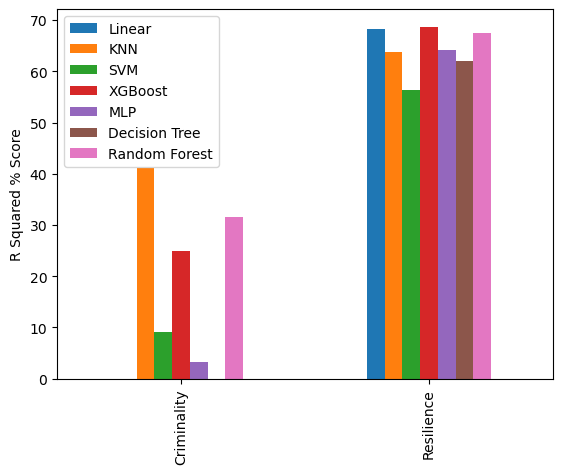

In [62]:
data = {'Linear': {'Criminality': 0, 'Resilience': 68.22},
        'KNN': {'Criminality': 41.13, 'Resilience': 63.68},
        'SVM': {'Criminality': 9.05, 'Resilience': 56.36},
        'XGBoost': {'Criminality': 24.93, 'Resilience': 68.71},
        'MLP': {'Criminality': 3.18, 'Resilience': 64.22},
        'Decision Tree': {'Criminality': 0, 'Resilience': 61.95},
        'Random Forest': {'Criminality': 31.59, 'Resilience': 67.53}}
df = pd.DataFrame(data)
df.plot.bar(ylabel="R Squared % Score") 

In [63]:
df

,Linear,KNN,SVM,XGBoost,MLP,Decision Tree,Random Forest
Criminality,0.00,41.13,9.05,24.93,3.18,0.00,31.59
Resilience,68.22,63.68,56.36,68.71,64.22,61.95,67.53


### Results Analysis

In [32]:
df = pd.DataFrame(linear_res.steps[0][1].components_)
df.columns = X_train_data.columns
df

,Population mid-year estimates (millions),Population mid-year estimates for males (millions),Population mid-year estimates for females (millions),Sex ratio (males per 100 females),Population aged 0 to 14 years old (percentage),Population aged 60+ years old (percentage),Population density,Surface area (thousand km2),GDP in current prices (millions of US dollars),GDP per capita (US dollars),...,GDP real rates of growth (percent),Students enrolled in primary education (thousands),Gross enrollment ratio - Primary (male),Gross enrollment ratio - Primary (female),Students enrolled in lower secondary education (thousands),Gross enrollment ratio - Lower secondary level (male),Gross enrollment ratio - Lower secondary level (female),Students enrolled in upper secondary education (thousands),Gross enrollment ratio - Upper secondary level (male),Gross enrollment ratio - Upper secondary level (female)
0,0.031944,0.034571,0.029431,0.002187,0.504800,-0.465905,-0.014692,0.039773,-0.080123,-0.140905,...,0.080302,0.096027,0.002962,-0.056099,0.008544,-0.370754,-0.331160,-0.034177,-0.340071,-0.327558
1,0.437732,0.443865,0.431914,-0.022186,-0.013549,0.041078,-0.021396,0.054898,0.166659,-0.010527,...,0.014255,0.343392,0.016152,0.000577,0.338357,0.038910,0.024650,0.353607,-0.002816,-0.013913
2,0.014498,0.009408,0.019381,-0.123035,-0.123003,0.503209,-0.079982,0.018096,0.095644,0.093967,...,0.082339,-0.054008,-0.416410,-0.460320,-0.051977,-0.362048,-0.376241,-0.039690,-0.007761,-0.102923
3,-0.018929,-0.031842,-0.006596,-0.244610,-0.104626,0.431414,0.049938,-0.023704,0.068329,-0.043634,...,-0.217813,0.003668,0.509307,0.471277,-0.011930,-0.242959,-0.181646,-0.035853,-0.229394,-0.229876
4,0.018879,0.021633,0.016222,-0.075957,-0.006819,0.156561,-0.081255,-0.038473,-0.172335,-0.001037,...,0.906931,0.113064,0.158537,0.161117,-0.011297,-0.037242,0.001011,-0.060295,0.066076,0.065401
5,-0.037402,-0.027771,-0.046596,0.401208,-0.002508,-0.178748,0.187315,-0.060113,0.414527,0.490167,...,0.191676,-0.140381,0.128242,0.141884,-0.040232,-0.190215,-0.160113,0.011023,0.142038,0.019159
6,-0.069535,-0.085139,-0.054658,-0.445388,0.615105,0.099350,-0.318238,0.091428,0.255986,-0.011870,...,0.003975,-0.122228,0.043826,0.027831,-0.018578,0.058699,0.067488,0.095446,0.247011,0.244824
7,0.045901,0.059036,0.033339,0.132126,0.039233,-0.013432,-0.400963,0.167003,-0.302517,0.465548,...,-0.251958,0.261138,0.165297,0.043746,-0.012907,-0.157837,-0.229549,-0.099601,0.327921,0.171568
8,0.056085,0.052874,0.059185,-0.250406,0.289561,0.089600,0.743445,-0.288177,-0.156473,0.194671,...,-0.083321,0.134422,-0.031842,-0.036747,-0.004779,-0.038506,-0.047706,-0.078099,0.224250,0.153025


In [34]:
df.T.idxmax()

0       Population aged 0 to 14 years old (percentage)
1    Population mid-year estimates for males (milli...
2           Population aged 60+ years old (percentage)
3              Gross enrollment ratio - Primary (male)
4                   GDP real rates of growth (percent)
5                          GDP per capita (US dollars)
6       Population aged 0 to 14 years old (percentage)
7                          GDP per capita (US dollars)
8                                   Population density
dtype: object

In [42]:
print("\n".join([f"{col}: {coef:.2f}" for col, coef in enumerate(linear_res.steps[1][1].coef_)]))

0: -0.20
1: 0.02
2: 0.04
3: -0.03
4: 0.18
5: 0.20
6: 0.12
7: 0.15
8: 0.14


In [60]:
projected_coeffs = [(col, c) for col,c in zip(X_train_data.columns,linear_res.steps[1][1].coef_ @ linear_res.steps[0][1].components_)]
projected_coeffs.sort(key=lambda x:-abs(x[1]))
pd.DataFrame(projected_coeffs)

,0,1
0,GDP per capita (US dollars),0.224055
1,Gross enrollment ratio - Upper secondary level...,0.223649
2,Gross enrollment ratio - Upper secondary level...,0.159242
3,GDP real rates of growth (percent),0.145440
4,Population aged 60+ years old (percentage),0.117480
5,Gross enrollment ratio - Primary (male),0.043851
6,GDP in constant 2015 prices (millions of US do...,0.039073
7,GDP in current prices (millions of US dollars),0.038854
8,Gross enrollment ratio - Primary (female),0.037246
9,Surface area (thousand km2),-0.027367


### Overfitting evaluation:

<Axes: ylabel='R Squared % Score'>

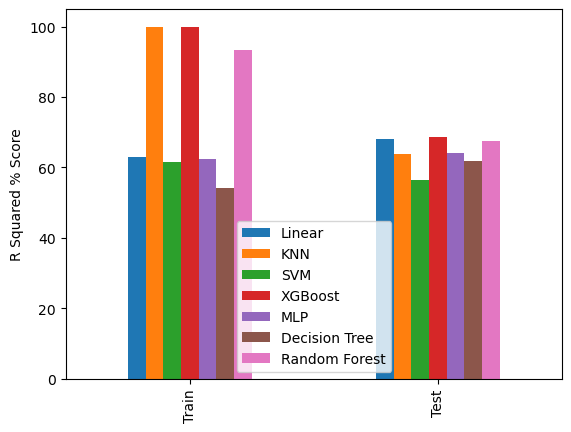

In [3]:
train_df = pd.DataFrame({'Linear': {'Train': 62.83, 'Test': 68.22},
        'KNN': {'Train': 100.00, 'Test': 63.68},
        'SVM': {'Train': 61.45, 'Test': 56.36},
        'XGBoost': {'Train': 100.00, 'Test': 68.71},
        'MLP': {'Train': 62.28, 'Test': 64.22},
        'Decision Tree': {'Train': 54.04, 'Test': 61.95},
        'Random Forest': {'Train': 93.30, 'Test': 67.53}})
train_df.plot.bar(ylabel="R Squared % Score")

In [4]:
train_df

,Linear,KNN,SVM,XGBoost,MLP,Decision Tree,Random Forest
Train,62.83,100.00,61.45,100.00,62.28,54.04,93.30
Test,68.22,63.68,56.36,68.71,64.22,61.95,67.53
